![CDS 411 logo](../../img/cds-411-logo.png)

# Class 15: Data-driven modeling II

---

![CC BY-SA 4.0 license](../../img/cc-by-sa.png)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

## Load packages

In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedKFold

Select a random seed for notebook reproducibility.

In [2]:
np.random.seed(862604190)

## Load data

### The *Filip* dataset

Source: <https://www.itl.nist.gov/div898/strd/lls/data/Filip.shtml>

Last class we took a look at the *Filip* dataset. The model that generated this dataset was a polynomial summation, $y=\beta_{0}+\beta_{1}x+\beta_{2}x^{2}+\beta_{3}x^{3}+\dots{}$.

In [3]:
filip_csv_path = Path("../../data/nist/filip.csv")
filip_df = pd.read_csv(filip_csv_path)

The data looks as follows:

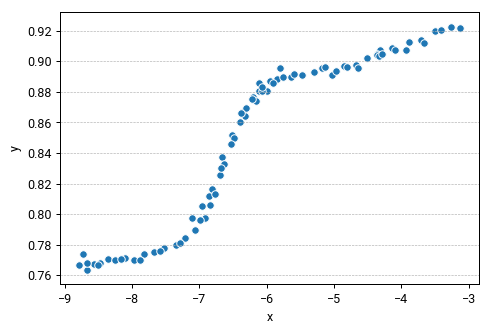

In [4]:
fig, ax = plt.subplots(dpi=90)
sns.scatterplot(x="x", y="y", data=filip_df, ax=ax);

Last time, we used the `statsmodels` package to fit the formula $y=\beta_{0}+\beta_{1}x+\beta_{2}x^2+\beta_{3}x^3$ to the data.

I glossed over the details underpinning how the `statsmodels` package worked, because, while it is a useful package to know how to use, it is not the main one I want to use. Instead, we need to learn how to perform the same type of fit using the powerful `scikit-learn` package.

## What is `scikit-learn`?

[scikit-learn](http://scikit-learn.org) is the premiere machine learning package for Python, similar to what [caret](https://topepo.github.io/caret/) is for the R language.

![scikit-learn front page](../../img/scikit-learn-frontpage.png)

If you use Python and plan to do something with machine learning, you **will** be using this package. It's worth learning how to navigate using it, even for simple tools such as linear regression.

So what kinds of problems should you use it for? The `scikit-learn` documentation provides [a nice overview of this](http://scikit-learn.org/stable/tutorial/basic/tutorial.html#machine-learning-the-problem-setting):

> In general, a learning problem considers a set of n [samples](https://en.wikipedia.org/wiki/Sample_(statistics)) of data and then tries to predict properties of unknown data. If each sample is more than a single number and, for instance, a multi-dimensional entry (aka [multivariate](https://en.wikipedia.org/wiki/Multivariate_random_variable) data), it is said to have several attributes or **features**.
>
> Learning problems fall into a few categories:
>
> *   [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning), in which the data comes with additional attributes that we want to predict \[...\] This problem can be either:
>
>     *    [classification](https://en.wikipedia.org/wiki/Classification_in_machine_learning): samples belong to two or more classes and we want to learn from already labeled data how to predict the class of unlabeled data.
>          \[...\]
> 
>     *    [regression](https://en.wikipedia.org/wiki/Regression_analysis): if the desired output consists of one or more continuous variables, then the task is called regression.
>          \[...\]
> 
> *   [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning), in which the training data consists of a set of input vectors x without any corresponding target values.

## What is in the package?

A lot! Many of the steps to fitting any given model follow a similar workflow, so it's been possible to bring many models and techniques to bear under the single umbrella of `scikit-learn`. Just a quick sampling of the [User Guide](http://scikit-learn.org/stable/user_guide.html) table of contents gives you an idea of what's available:

1.  **Supervised learning**
    *   Models classes include: generalized linear models, kernel ridge regression, support vector machines, naive bayes, decision trees, ensemble methods, supervised neural network models, and more
2.  **Unsupervised learning**
    *   Model classes include: Clustering, signal decomposition, density estimation, unsupervised neural network models, and more
3.  **Model selection and evaluation**
    *   Cross-validation, hyper-parameter tuning, model evaluation, model persistence, and validation curves
4.  **Dataset transformations**
    *   Helpful tools that include: feature extraction, data preprocessing, imputation of missing values, and more
5.  **Dataset loading utilities**
    *   Toy and example datasets for practice
6.  **Computing with scikit-learn**
    *   Tools and strategies for optimizing and scaling your computational work

## Where can I find help with using scikit-learn?

The official documentation is a great place to start. There are several links in the documentation that you can consult:

*   Official user guide: http://scikit-learn.org/stable/user_guide.html

*   Official tutorials: http://scikit-learn.org/stable/tutorial/index.html

*   Official examples: http://scikit-learn.org/stable/auto_examples/index.html

*   External resources, videos and talks: http://scikit-learn.org/stable/presentations.html

### There's a lot there and it's overwhelming, anything to start with first?

Give the tutorial titled **A tutorial on statistical-learning for scientific data processing** a look: <http://scikit-learn.org/stable/tutorial/statistical_inference/index.html#stat-learn-tut-index>.

Jake VanderPlas puts out a lot of useful tutorials and materials on scientific computing with Python, so the following are worth a look:

*   **Tutorial: scikit-learn - Machine Learning in Python with Contributor Jake VanderPlas**: https://youtu.be/cHZONQ2-x7I

*   **Scikit-learn tutorials for the Scipy 2013 conference by Gaël Varoquaux, Jake Vanderplas, and Olivier Grisel**

    *   *Videos*: Part 1, http://conference.scipy.org/scipy2013/tutorial_detail.php?id=107, and Part 2, http://conference.scipy.org/scipy2013/tutorial_detail.php?id=111

    *   *Notebooks for tutorial on GitHub*: https://github.com/jakevdp/sklearn_scipy2013

### scikit-learn flow chart

![Flow chart for scikit-learn](../../img/scikit-learn-flow-chart.png)

Interactive version of this chart available here: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## scikit-learn worked example: linear regression on Filip dataset

To ease us into the world of `scikit-learn`, we start by reproducing what we did last time, which was using ordinary least-squares regression to fit the *Filip* dataset using the formula $y=\beta_{0}+\beta_{1}x+\beta_{2}x^{2}+\beta_{3}x^{3}$. First, in order to use `scikit-learn`, you need to have it installed. The `environment.yaml` file I distributed earlier in the semester should have taken care of this for you. But, just in case it hasn't, it is available through Anaconda with the command:

```bash
conda install scikit-learn
```

Then, at the top of your notebook, you will need to import the following:

```python
from sklearn.linear_model import LinearRegression
```

Unlike with `statsmodels`, where we could write down a formula, in `scikit-learn` we instead need to create columns that represent the different powers in the polynomial. First, let's make a copy of the *Filip* data frame so that we can always go back to the beginning, if necessary:

In [5]:
filip_df_poly = filip_df.copy()

Next, we need to create the columns. For the above fit, we need columns that represent $x^2$ and $x^3$. Let's set up a loop to automate creating them.

In [6]:
for n in np.arange(2, 4):
    filip_df_poly[f"x**{n}"] = filip_df_poly["x"] ** n

Looking at the first few rows in the data frame lets us confirm the above loop worked as expected:

In [7]:
filip_df_poly.head()

,y,x,x**2,x**3
0,0.8116,-6.860121,47.061259,-322.845927
1,0.9072,-4.324130,18.698101,-80.853019
2,0.9052,-4.358625,18.997612,-82.803469
3,0.9039,-4.358427,18.995884,-82.792168
4,0.8053,-6.955852,48.383882,-336.551143


To perform linear regression, we instantiate the `LinearRegression` object as follows:

In [8]:
lm = LinearRegression()

To create a fit, we use the `lm.fit()` method, which requires two keywords, `X` and `y`. `X` takes the dependent variables we are fitting to (the powers of $x$, in this example). `y` takes the independent variable, or outputs, we are trying to predict with the regression (the variable $y$ in this example). We'll specify the independent variable and dependent variables as follows:

In [9]:
independent_var = "y"
dependent_vars = ["x", "x**2", "x**3"]

We now use these in `lm.fit()` as follows:

In [10]:
smf_filip_fit = lm.fit(X=filip_df_poly[dependent_vars], y=filip_df_poly[independent_var])

The fitting coefficients (the parameters $\beta_{0}$, $\beta_{1}$, $\beta_{2}$, and $\beta_{3}$) are:

In [11]:
pd.DataFrame({
    "coefficient": ["beta_0", "beta_1", "beta_2", "beta_3"],
    "value": np.concatenate([[smf_filip_fit.intercept_], smf_filip_fit.coef_]),
})

,coefficient,value
0,beta_0,0.390271
1,beta_1,-0.303364
2,beta_2,-0.053719
3,beta_3,-0.002726


We use the `predict` method to generate our model curve that we can compare with the data:

In [12]:
smf_filip_predict_df = pd.DataFrame({
    "x": np.arange(-9, -3, 0.01),
    "x**2": np.arange(-9, -3, 0.01) ** 2,
    "x**3": np.arange(-9, -3, 0.01) ** 3,
})
smf_filip_predict_df["y"] = smf_filip_fit.predict(smf_filip_predict_df)

Visualizing both on the same plot, we get:

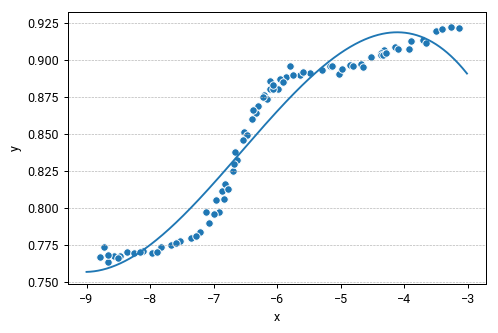

In [13]:
fig, ax = plt.subplots(dpi=90)
sns.scatterplot(x="x", y="y", data=filip_df, ax=ax)
sns.lineplot(x="x", y="y", data=smf_filip_predict_df, ax=ax);

Comparing with the statsmodels fit, we see that we have the same result:

![Statmodels cubic fit to Filip dataset](../../img/filip-statsmodels-cubic-fit.png)

## Trying other fits to *Filip*

We've seen all this already. Let's take a look at how the fit to the *Filip* dataset changes as we increase the number of terms in the polynomial expansion. To do this, we'll first need to add even more columns to the data frame so that we can perform a range of fits:

In [14]:
for n in np.arange(4, 16):
    filip_df_poly[f"x**{n}"] = filip_df_poly["x"] ** n

Now we have far more columns in the data frame

In [15]:
filip_df_poly.head()

,y,x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9,x**10,x**11,x**12,x**13,x**14,x**15
0,0.8116,-6.860121,47.061259,-322.845927,2214.762094,-15193.535763,104229.492448,-715026.920996,4.905171e+06,-3.365007e+07,2.308435e+08,-1.583615e+09,1.086379e+10,-7.452689e+10,5.112635e+11,-3.507329e+12
1,0.9072,-4.324130,18.698101,-80.853019,349.618968,-1511.797883,6537.210647,-28267.748970,1.222334e+05,-5.285532e+05,2.285533e+06,-9.882941e+06,4.273512e+07,-1.847922e+08,7.990656e+08,-3.455264e+09
2,0.9052,-4.358625,18.997612,-82.803469,360.909276,-1573.068212,6856.414522,-29884.540122,1.302555e+05,-5.677349e+05,2.474544e+06,-1.078561e+07,4.701042e+07,-2.049008e+08,8.930857e+08,-3.892626e+09
3,0.9039,-4.358427,18.995884,-82.792168,360.843598,-1572.710389,6854.543023,-29875.023648,1.302081e+05,-5.675025e+05,2.473418e+06,-1.078021e+07,4.698476e+07,-2.047796e+08,8.925170e+08,-3.889970e+09
4,0.8053,-6.955852,48.383882,-336.551143,2341.000068,-16283.650894,113266.671807,-787866.248553,5.480281e+06,-3.812003e+07,2.651573e+08,-1.844395e+09,1.282934e+10,-8.923899e+10,6.207332e+11,-4.317729e+12


We set up a loop to create a series of fits:

In [16]:
independent_var = "y"
dependent_vars = ["x"]

filip_polyfit_predict_df = pd.DataFrame({
    "x": np.arange(-8.90, -2.9, 0.01),
})

for n in range(1, 16):
    if n > 1:
        dependent_vars.append(f"x**{n}")
        filip_polyfit_predict_df[f"x**{n}"] = \
            np.arange(-8.90, -2.9, 0.01) ** n
        
    filip_polyfit = lm.fit(
        X=filip_df_poly[dependent_vars],
        y=filip_df_poly[independent_var],
    )
    filip_polyfit_predict_df[f"{n}"] = \
        filip_polyfit.predict(filip_polyfit_predict_df[dependent_vars])

Now let's reshape the data frame using melt. Instead of having 15 columns named `y_1` through `y_15`, we'll instead have a column called `n` that specifies the polynomial degree and a column `y_predicted` that contains the predicted value of $y$.

In [17]:
filip_polyfit_predict_df_reshaped = filip_polyfit_predict_df \
    .melt(id_vars=dependent_vars,
          value_vars=[f"{n}" for n in range(1, 16)],
          var_name="Degree",
          value_name="y_predicted")

Let's now view the results in a series of faceted windows.

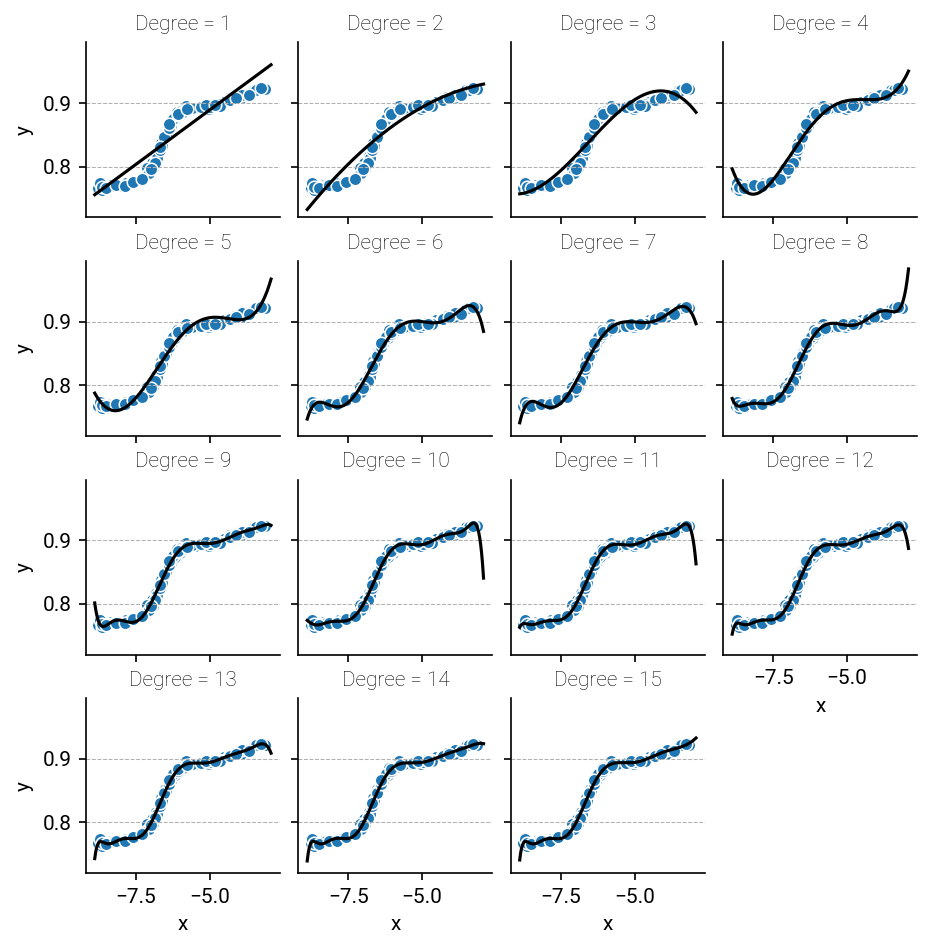

In [18]:
g = sns.FacetGrid(
    filip_polyfit_predict_df_reshaped,
    col="Degree",
    col_wrap=4,
    col_order=[f"{n}" for n in range(1, 16)],
    hue_kws={"color": ["k"]},
    sharex=True,
    sharey=True,
)

# Plots the predicted values as black lines
g = g.map(plt.plot, "x", "y_predicted")

# Plots the data points within each facet
for idx in range(15):
    sns.scatterplot(x="x", y="y", data=filip_df_poly, ax=g.axes[idx])

g.fig.set_dpi(150)
g.fig.set_size_inches(6, 6)

An alternate way to plot the windows, which is a little more complicated, but offers more control, is as follows:

```python
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 8), dpi=120,
                       sharex=True, sharey=True)

poly_degree = 0
for nrow in range(4):
    for ncol in range(4):
        poly_degree += 1
        
        if poly_degree < 16:
            sns.scatterplot(
                x="x",
                y="y",
                data=filip_df_poly, ax=ax[nrow][ncol]
            )
            sns.lineplot(
                x="x",
                y=f"y_{poly_degree}",
                data=smf_filip_polyfit_predict_df,
                color="black",
                ax=ax[nrow][ncol]
            )
            ax[nrow][ncol].set_title(f"Degree {poly_degree}")
            ax[nrow][ncol].set_ylabel("y")
            
plt.tight_layout();
```

**So... which model is best? How can we even tell?**

## Model selection using cross-validation

* How should we compare and rank models?

* This is what **model selection** is about, computing scores and measures of model performance for different models, and selecting the best choice.

* Cross-validation is a method that can be used to compare relative model performance using only training data 

* Cross-validation refers to the procedure of removing portions of a dataset, training the model on the remaining portion, and then trying to predict the values of the data you removed

* A popular flavor of cross-validation (especially among data scientists) is called **k-fold cross-validation**

* **Basic idea:** Estimate how robust your model is by systematically removing different chunks (the "folds") of the dataset, repeating the fitting process, then testing its predictive power on the folds

![cross validation schematic](../../img/cross-validation-schematic.png)

* The above example illustrates a *5-fold*, or $k=5$, cross-validation.

* Each fold will act as a testing set, with the remaining $k-1$ folds used to train the model.

* Fit model, predict values in testing set, then calculate a score, such as the mean-squared prediction error (MSE)

* MSE gives an estimate of how well the model works as a predictor

* MSE is general-purpose and allows you to compare models of many types

* For linear regression, you can also use model-specific measures, such as $R^2$

### Cross-validation using `scikit-learn`

To use cross-validation, you will need to import additional modules from `scikit-learn`:

```python
from sklearn.model_selection import cross_val_score, RepeatedKFold
```

`RepeatedKFold` is an implementation of *k-fold cross-validation* that allows you to repeat the procedure multiple times, randomizing the data within each repetition. By doing this, you can obtain better statistical averaging, which can be particularly useful if the dataset is not so large.

`cross_val_score` is the function that takes the data and cross-validation splitting as input, runs the fitting procedure, and computes a specified score at the end.

**A list of scores you can compute during a cross-validation run:** <http://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules>

Let's modify our loop to run a series of k-fold cross-validations for our different polynomial formulas.

In [19]:
independent_var = "y"
dependent_vars = ["x"]

filip_poly_cv_scores = {
    "n": [],
    "mse": [],
    "mse_sd": [],
    "r**2": [],
    "r**2_sd": [],
}

for n in range(1, 16):
    if n > 1:
        dependent_vars.append(f"x**{n}")
        
    rkf = RepeatedKFold(
        n_splits=10,
        n_repeats=100,
        random_state=int(np.round(np.random.uniform(0, 2**31), decimals=0)),
    )
    
    # Cross-validated mean-squared error score
    mse_cv_score = cross_val_score(
        lm,
        filip_df_poly[dependent_vars],
        filip_df_poly[independent_var],
        scoring="neg_mean_squared_error",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )

    # Cross-validated R**2 score
    r2_cv_score = cross_val_score(
        lm,
        filip_df_poly[dependent_vars],
        filip_df_poly[independent_var],
        scoring="r2",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )

    filip_poly_cv_scores["n"].append(n)
    filip_poly_cv_scores["mse"].append(-np.mean(mse_cv_score))  # Get rid of negative sign
    filip_poly_cv_scores["mse_sd"].append(np.std(mse_cv_score))
    filip_poly_cv_scores["r**2"].append(np.mean(r2_cv_score))
    filip_poly_cv_scores["r**2_sd"].append(np.std(r2_cv_score))

# Convert dictionary to data frame
filip_poly_cv_scores_df = pd.DataFrame(filip_poly_cv_scores)

Let's see how the various models perform:

In [20]:
filip_poly_cv_scores_df

,n,mse,mse_sd,r**2,r**2_sd
0,1,0.000387,0.000120,0.815206,0.245704
1,2,0.000299,0.000115,0.860383,0.147108
2,3,0.000221,0.000082,0.887993,0.210553
3,4,0.000093,0.000035,0.959409,0.033963
4,5,0.000102,0.000071,0.955175,0.044956
5,6,0.000040,0.000025,0.981716,0.022905
6,7,0.000044,0.000062,0.975425,0.132341
7,8,0.000035,0.000078,0.984792,0.036522
8,9,0.000030,0.000126,0.986491,0.061791
9,10,0.000028,0.000098,0.988350,0.038857


Visualize the relative performance

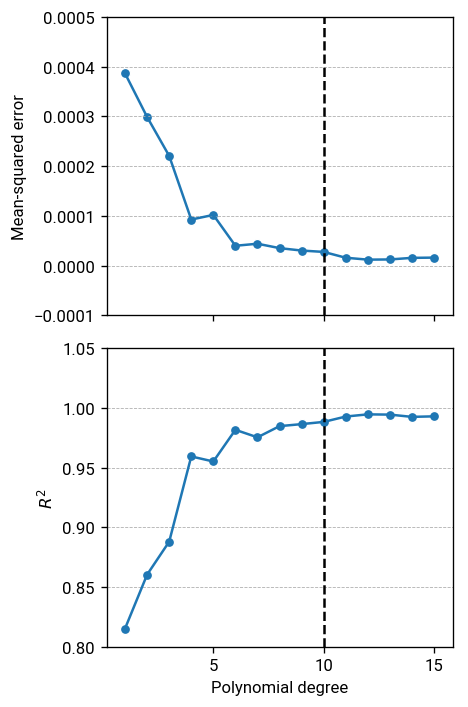

In [21]:
fig, ax = plt.subplots(nrows=2, dpi=120, figsize=(4, 6), sharex=True)
sns.scatterplot(x="n", y="mse", data=filip_poly_cv_scores_df, ax=ax[0])
sns.lineplot(x="n", y="mse", data=filip_poly_cv_scores_df, ax=ax[0])
ax[0].axvline(x=10, linestyle="--", color="k")  # "True" polynomial degree
ax[0].set_ylim([-0.0001, 0.0005])
ax[0].set_xlabel(r"Polynomial degree")
ax[0].set_ylabel(r"Mean-squared error")

sns.scatterplot(x="n", y="r**2", data=filip_poly_cv_scores_df, ax=ax[1])
sns.lineplot(x="n", y="r**2", data=filip_poly_cv_scores_df, ax=ax[1])
ax[1].axvline(x=10, linestyle="--", color="k")  # "True" polynomial degree
ax[1].set_ylim([0.80, 1.05])
ax[1].set_xlabel(r"Polynomial degree")
ax[1].set_ylabel(r"$R^{2}$")

fig.tight_layout();